# How can you determine home value?

> ## Goal: 

* Find features that will best determine home values.
* Use features to develop a machine learning model to predict home values.
* This information could be used to determine how much a house could or should cost based on current market

>> # Executive Summary
> * Acquire & prep
> * Exploration
> * Models - Create, Compare & Decide
> * Conclusion and Summary

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
from math import sqrt
from scipy.stats import pearsonr, spearmanr

from env import get_connection
import wrangle_zillow
import prepare
import model_functions as results


# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

>> # Acquire the data

>- I originally acquired the data from Codeup SQL server, I then saved it to a csv
>- The dataset, before preparation has 63 columns and 52441 rows
>- Each observation (row) represents details about each home
>- Each column represents variables associated with the observations of each home

In [2]:
# Calling the function to acquire and prep the data
df = wrangle_zillow.wrangle_zillow()

fips column ignored


> ### Internet Search
According to opendoor.com, these are 8 critical factors that influence a home’s value:
* Neighborhood comps
* Location
* Homesize & usable space
* Age & Condition
* ~Upgrades & Updates~
* ~Local Market~
* ~Economic indicators~
* ~Interest rates~

> # Prepare the data

- As part of my planning step, I had some ideas of the questions I wanted to answer, 
    This helped me decide what information was truly necessary for me to reach my conlcusions based on 
    what I was asking
- Knowing my preliminary questions, I decided to drop numerous columns I felt held 
    little to no value to help me reach my conclusions, such as extreme outliers, and minimal null values
- During some initial exploration of the data, I noticed the zipcode column had 11 rows with a 6 digit zipcode that       started with a number that didn't coincide with the other zipcodes, based on the fact that I still had 51696 rows(or observations) left, I decided to remove those rows
- Once I felt I had all the data I needed and wanted to explore with, I created dummy variables to create binary 
    values for my data
- After preparation, my dataset was 11 columns and 42493 rows leaving me with an ample amount of data to produce a decent product

In [3]:
# seeing what I'm dealing with
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42493 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bath               42493 non-null  int64  
 1   bed                42493 non-null  int64  
 2   sqft               42493 non-null  float64
 3   fin_sqft           42493 non-null  float64
 4   fips               42493 non-null  int64  
 5   full_bath          42493 non-null  float64
 6   lotsize            42493 non-null  float64
 7   zipcode            42493 non-null  float64
 8   rooms              42493 non-null  float64
 9   yearbuilt          42493 non-null  int64  
 10  taxvaluedollarcnt  42493 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 3.9 MB


>> # Data Dictionary

|Feature|              Definition|
| :------|:------|
|bath|                      - tells how many half and full bathrooms in the house|
|bed|                       - tells how many bedrooms in the house|
|sqft|                      - tells the total square footage of the house itself|
|fin_sqft|                  - tells finished square footage of the house itself|
|fips|                      - tells the county code of the property| 
|full_bath|                 - tells the amount of full bathrooms only|
|lotsize|                   - tells the size of the entire property lot in square feet|
|zipcode|                       - tells what zip code the house is located |
|rooms|                     - tells how many total rooms there are in the house|
|yearbuilt|                 - tells you the year the house was built|
|taxvaluedollarcnt (TARGET)|         - tells you the value of the home|

> ## Splitting the data

In [4]:
# calling function to split data
train, val, test = prepare.train_val_test(df)
train.shape, val.shape, test.shape

((29745, 11), (7648, 11), (5100, 11))

> # Exploration

* Does the amount of bedrooms affect value?
* Does the amount of bathrooms affect the value? 
* Does the size of the home affect the value of the home?

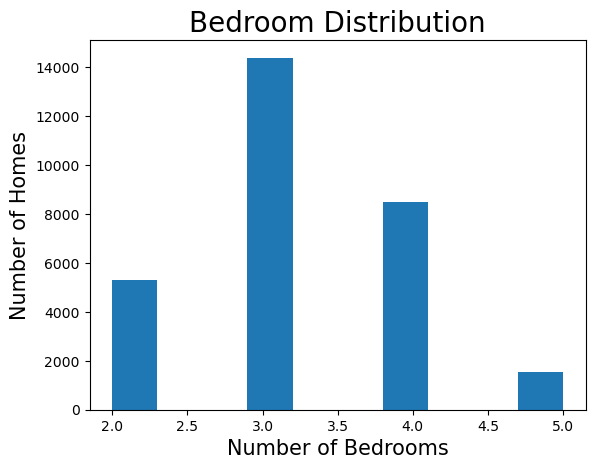

In [5]:
# plotting histogram of bedroom distro
train['bed'].hist(grid = False)
plt.ylabel('Number of Homes', fontdict = { 'fontsize': 15})
plt.xlabel('Number of Bedrooms', fontdict = { 'fontsize': 15})
plt.title('Bedroom Distribution', fontdict = { 'fontsize': 20})
plt.show()

> Takeaway - This just shows the amount of bedrooms per home

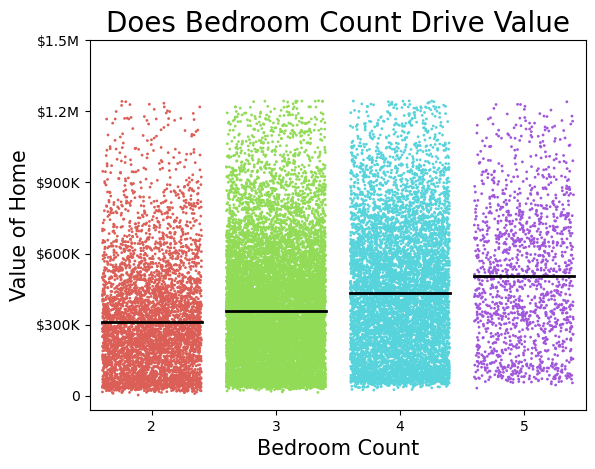

In [6]:
# Creating a visual displaying amount distro comapred to mean
p = sns.stripplot(y = train.taxvaluedollarcnt, x = train.bed, data = train, size = 2, jitter = .4, palette = 'hls')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="bed",
            y="taxvaluedollarcnt",
            data=train,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.ylabel('Value of Home', fontdict = { 'fontsize': 15})
plt.xlabel('Bedroom Count', fontdict = { 'fontsize': 15})
plt.title('Does Bedroom Count Drive Value', fontdict = { 'fontsize': 20})
labels = ['0', '$300K', '$600K', '$900K', '$1.2M', '$1.5M']
plt.yticks(ticks = (0, 300000, 600000, 900000, 1200000, 1500000), labels = labels)
plt.show()

> Takeaway - The mean lines illustrate a very slight increase in value the more you increase the bedroom count, but due to the amount of observations, it does not seem very significant in predicting value.

In [7]:
# Normal distribution so running a pearsonR stat test
r, p_value = pearsonr(train.bed, train.taxvaluedollarcnt)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

Correlation Coefficient: 0.2001037558377394
P-value: 2.697659182525196e-266


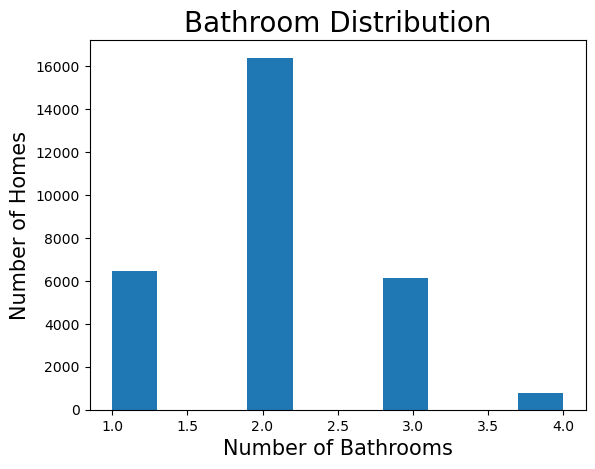

In [8]:
# plotting histogram of bathroom distro
train['bath'].hist(grid = False)
plt.ylabel('Number of Homes', fontdict = { 'fontsize': 15})
plt.xlabel('Number of Bathrooms', fontdict = { 'fontsize': 15})
plt.title('Bathroom Distribution', fontdict = { 'fontsize': 20})
plt.show()

> Takeaway - This just shows the amount of bathrooms per home

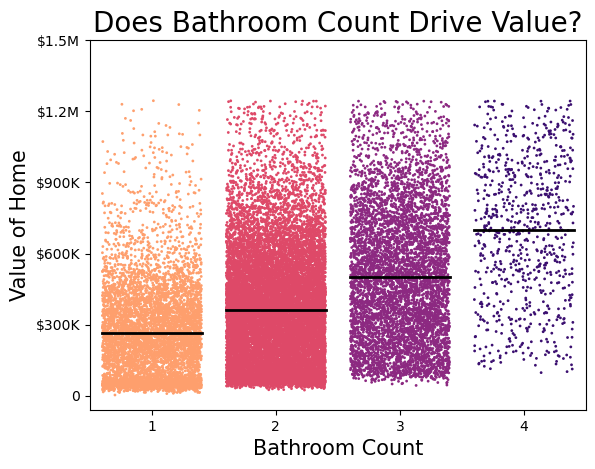

In [9]:
# Creating a visual displaying amount distro comapred to mean
p = sns.stripplot(y = train.taxvaluedollarcnt, x = train.bath, data = train, size = 2, jitter = .4, palette = 'magma_r')
plt.title('Does Bathroom Count Drive Value?', fontdict = { 'fontsize': 20})
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="bath",
            y="taxvaluedollarcnt",
            data=train,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.ylabel('Value of Home', fontdict = { 'fontsize': 15})
plt.xlabel('Bathroom Count', fontdict = { 'fontsize': 15})
labels = ['0', '$300K', '$600K', '$900K', '$1.2M', '$1.5M']
plt.yticks(ticks = (0, 300000, 600000, 900000, 1200000, 1500000), labels = labels)
plt.show()


> Takeaway - The mean lines illustrate a more significant increase in value the more you increase the bathroom count as opposed to bedroom count, this shows that this could be a better preditive indicator

In [10]:
# Normal distribution so running a pearsonR stat test
r, p_value = pearsonr(train.bath, train.taxvaluedollarcnt)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

Correlation Coefficient: 0.36048975463581134
P-value: 0.0


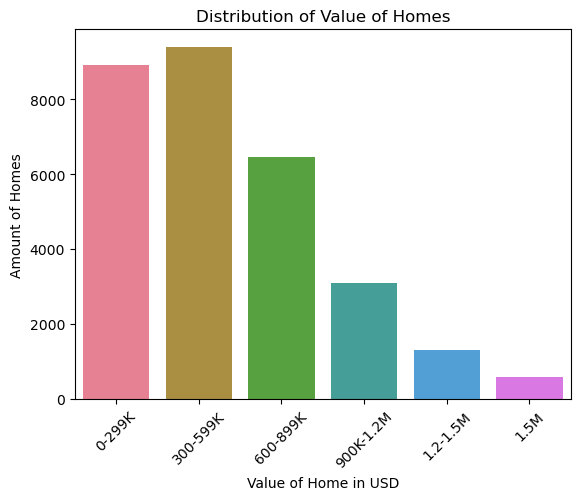

In [11]:
#creating bins to see distribution of homes by value
value_bins = pd.cut(train.taxvaluedollarcnt, 6)
sns.countplot(x = value_bins, data=train, palette = 'husl')
plt.xlabel('Value of Home in USD')
plt.ylabel('Amount of Homes')
plt.title('Distribution of Value of Homes')
x = [0, 1, 2, 3, 4, 5]
labels = ['0-299K', '300-599K', '600-899K', '900K-1.2M', '1.2-1.5M', '1.5M']
plt.xticks(x, labels, rotation =45)
plt.show()

> Takeaway - This just shows the distribution of homes in six equally divided groups by value

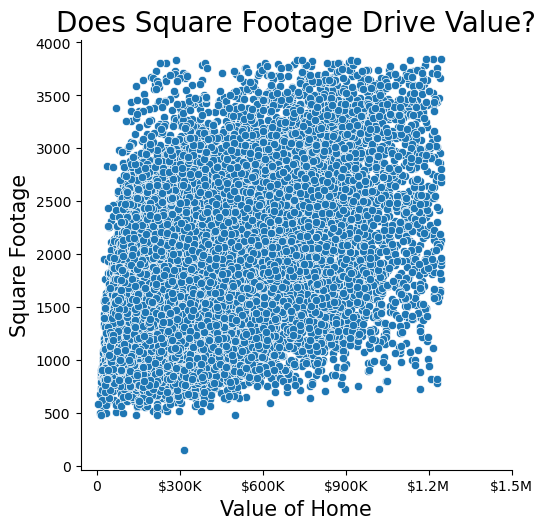

In [12]:
#ran a pairplot to visualize distro
sns.pairplot(train, y_vars = ['sqft'], x_vars = ['taxvaluedollarcnt'], 
            corner = True, height = 5)
plt.xlabel('Value of Home', fontdict = { 'fontsize': 15})
plt.ylabel('Square Footage', fontdict = { 'fontsize': 15})
plt.title('Does Square Footage Drive Value?', fontdict = { 'fontsize': 20})
labels = ['0', '$300K', '$600K', '$900K', '$1.2M', '$1.5M']
plt.xticks(ticks = (0, 300000, 600000, 900000, 1200000, 1500000), labels = labels)
plt.show()

> Takeaway - There seems to be some evidence that square footage can help predict value, there are large homes that cost very little as well as very small homes that could cost you an arm and a leg, maybe your first born. Overall there seems to be a realtionship between the two

In [13]:
# Not normally distributed so running a spearman's r stat test
r, p_value = spearmanr(train.sqft, train.taxvaluedollarcnt)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

Correlation Coefficient: 0.41479804378168667
P-value: 0.0


> # Exploration Summary
> * #### Bedroom count does not seem to be a good predictor of home value 
> * #### Bathroom count isn't a bad predictor, but also not a good one
> * #### Square footage is the best predictor out these three features, although it isn't great

In [14]:
#Creating dummies for modeling
df = prepare.zillow_dummies(df)
df.head()

,sqft,taxvalue,fips_6037,fips_6059,fips_6111,bed_2,bed_3,bed_4,bed_5,bath_1,bath_2,bath_3,bath_4
0,3100.0,1023282.0,0,1,0,0,0,1,0,0,0,1,0
1,1465.0,464000.0,0,0,1,1,0,0,0,1,0,0,0
2,1243.0,564778.0,0,1,0,0,1,0,0,0,1,0,0
3,2376.0,145143.0,1,0,0,0,0,1,0,0,0,1,0
5,738.0,218552.0,1,0,0,1,0,0,0,1,0,0,0


In [15]:
#Verifying split
train, val, test = prepare.train_val_test(df)
train.shape, val.shape, test.shape

((29745, 13), (7648, 13), (5100, 13))

> ### Establish a Baseline

In [16]:
#Creating a baseline across my splits
train['yhat_baseline'] = train['taxvalue'].mean()
val['yhat_baseline'] = val['taxvalue'].mean()
test['yhat_baseline'] = test['taxvalue'].mean()

In [17]:
#Calling function to create X and y trains
X_train, y_train, X_val, y_val, X_test, y_test = prepare.X_y_tvt(train, val, test)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((29745, 13), (29745,), (7648, 13), (7648,), (5100, 13), (5100,))

In [18]:
# creating variables to scale
X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled = prepare.X_y_tvt(train, val, test)

In [19]:
# Scaling the data
scaler, train_scaled, val_scaled, test_scaled = prepare.scale_splits_rb(train, 
                                                                        val, 
                                                                        test, 
                                                                        return_scaler = True)    

> # Baseline Results

In [20]:
#calling function to establish and get rmse of baseline
print("The baseline RMSE is: \n")
results.BL_rmse(y_train_scaled)

The baseline RMSE is: 

254940.9001486285


> # OLS (Linear regression) 

In [21]:
#Calling function to get rmse of linear regression
print("The train RMSE results for Linear regression is: \n")
results.OLS_train(X_train_scaled, y_train_scaled)
print("")
print("The validate RMSE results for Linear Regression is: \n")
results.OLS_val(X_val_scaled, y_val_scaled)

The train RMSE results for Linear regression is: 

221977.25035450887

The validate RMSE results for Linear Regression is: 

222972.5279746009


> # LASSO + LARS

In [22]:
##Calling function to get rmse of Lasso Lars
print("The train RMSE results for Lasso Lars is: \n")
results.LL_train(X_train_scaled, y_train_scaled)
print("")
print("The validate RMSE results for Lasso Lars is: \n")
results.LL_val(X_val_scaled, y_val_scaled)

The train RMSE results for Lasso Lars is: 

221977.25268363318

The validate RMSE results for Lasso Lars is: 

222972.52855859764


> # Polynomial regression


In [23]:
#Calling function to get rmse of Polynomial regression
print("The train RMSE results for Polynomial Regression is: \n")
results.PR_train(X_train_scaled, y_train_scaled)
print("")
print("The validate RMSE results for Polynomial Regression is: \n")
results.PR_val(X_val_scaled, y_val_scaled)

The train RMSE results for Polynomial Regression is: 

220570.62376025232

The validate RMSE results for Polynomial Regression is: 

220216.19891648827


# Comparing Models
* Linear Regression, Lasso Lars and Polynomial Regression models all performed better than baseline on train and validate
* Polynomial regression was the model selected as it performed the best on train and validate and was the only model that performed better on validate than the train. 
* While I could have went forward with any of the models based on their performance, I chose polynomial regression as it performed better than linear regression and Lasso Lars.

In [24]:
results.model_report()

,Model,Train Predictions,Validate Predictions
0,Linear Regression,221977.25,222972.52
1,Lasso + Lars,221977.25,222972.52
2,Polynomial Regression,220570.62,220216.19


> # Test Polynomial Regression

In [25]:
results.PR_test(X_test_scaled, y_test_scaled)

216849.44610074995


# Conclusions


>### Modeling
* The final model outperformed the baseline by about $40K. 

* Common sense might have you believe that size alone could be a good indicator of how much a home could be valued at. While this was the best indicator here, there are numerous other factors to be considered.  

>### Recommendations
* Don't solely look at the size of the home as a way to gauge the value of homes. It can serve as a good launching pad but would be best utilized when coupled with other factors.

* Quantities of bedrooms and bathrooms kind of coincides with teh size of the home as you have to have the space avaialable to fit the rooms, but having more bathrooms did have a slight indication that homes were more valuable the more bathrooms it had


>### Next Steps
* I would combine some features and create new columns such as combining garage, hottub, pool, fireplace, single story